### 1. Alle benötigten Bibliotheken importieren

In [31]:
import tensorflow as tf

import numpy as np # Lineare Algebra Operationen
import pandas as pd # Datenverarbeitung

import matplotlib.pyplot as plt # Graphen anzeigen usw.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend


### 2. MNIST Datensatz laden

In [32]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

values, counts = np.unique(y_train, return_counts=True)

dict_train = dict(zip(values, counts))
print(f"Train lables: {dict_train}")

values, counts = np.unique(y_test, return_counts=True)

dict_test = dict(zip(values, counts))
print(f"Test lables: {dict_test}")

Train lables: {np.uint8(0): np.int64(5923), np.uint8(1): np.int64(6742), np.uint8(2): np.int64(5958), np.uint8(3): np.int64(6131), np.uint8(4): np.int64(5842), np.uint8(5): np.int64(5421), np.uint8(6): np.int64(5918), np.uint8(7): np.int64(6265), np.uint8(8): np.int64(5851), np.uint8(9): np.int64(5949)}
Test lables: {np.uint8(0): np.int64(980), np.uint8(1): np.int64(1135), np.uint8(2): np.int64(1032), np.uint8(3): np.int64(1010), np.uint8(4): np.int64(982), np.uint8(5): np.int64(892), np.uint8(6): np.int64(958), np.uint8(7): np.int64(1028), np.uint8(8): np.int64(974), np.uint8(9): np.int64(1009)}


### Datensatz visualisieren

Der folgende Code wir 25 zufällige MNST-Ziffern auswählen und diese visualisieren

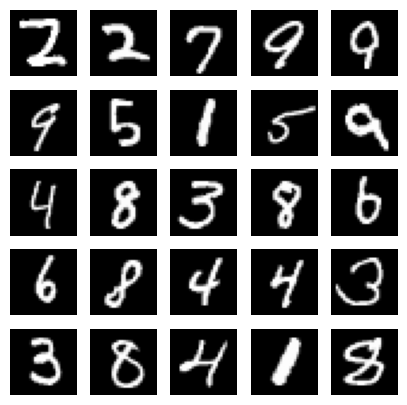

In [33]:
indizes = np.random.randint(0, x_train.shape[0], size=25)

images = x_train[indizes]

labels = y_train[indizes]

plt.figure(figsize=(5,5))

for i in range(len(indizes)):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    image = images[i]
    plt.imshow(image, cmap="gray")

plt.show()
plt.close("all")

### Ausgaben des Netzes definieren

In [34]:
anzahl_labels = len(np.unique(y_train))
print(anzahl_labels)

10


### One-Hot Encoding

- Zu diesem Zeitpunkt liegen die Labels im Zahlenform von 0 bis 9 vor.
- Skalar Darstellung der Labels ist nicht geeignet für die Vorhersageschicht (letzte/Ausgabeschicht) des neuronalen Netzwerks, die Wahrscheinlichkeiten pro Ausgabemöglichkeit ausgibt.
- Ein geeigneteres Format wird als "One-Hot-Vektor" bezeichnet, ein 10-dimensionaler Verktor, bei dem alle Elemente 0 sind, außer dem Index der Ziffernklasse.
- Beispiel: Für Label 2 ist der äquivalente One-Hot-Vektor [0,0,1,0,0,0,0,0,0,0]. Das erste Label hat den Index 0.

In [35]:
from tensorflow.keras.utils import to_categorical

print(y_test[0])

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(y_test[0])

7
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


### Daten Vorverarbeitung
- Im Deep Learning werden Daten in Tensoren gespeichert. Der Bergriff Tensor bezieht sich auf einen Skalar (0D-Tensor), einen Vektor (1D-Tensor), eine Matrix (2D-Tensor) und einen mehrdimensionalen Tensor.
- Die Eingabegröße der ersten Eingabe-Schicht von 0 bis 255 auf den Bereich von 0,0 bis 1,0 skaliert werden. Obwohl Rohpixelwerte direkt verwendet werden können, ist es besser, die Eingabedaten zu normalisieren, um große Gradientenwerte zu vermeiden, die das Training erschweren könnten.
- Auch die Ausgabe des Netzwerks werden normalisiert. Nach dem Training besteht die Möglichkeit, alles wieder auf die ganzzahligen Pixelwerte zurückzusetzen, indem der Ausgabetensor mit 255 multipliziert wird.
- Das vorgeschlagene Modell basiert auf MLP-Schichten. Daher wird erwartet, dass die Eingabe ein 1D-Tensor ist. Daher werden x_train und x_test entsprechend von [60000, 28,28] in [60000, 28 * 28] und [10000, 28 * 28] umgeformt.

In [36]:
bild_groesse = x_train.shape[1]
print(bild_groesse)

bild_groesse = bild_groesse * bild_groesse
print(bild_groesse)

# Reshape
x_train = np.reshape(x_train, [-1, bild_groesse])
x_test = np.reshape(x_test, [-1, bild_groesse])

# Skalieren
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


28
784


### Netwerkparamter setzen

Folgende Netzwerkparameter müssen gesetzt werden:

- batch_size: wie viele Daten für jedes Update der Modellparameter verwendet werden.
Beispiel mit 32 -> 32 Trainingsbeispiel werden eingegeben, bevor die Gewichtungen aktualisiert werden
-> Beeinflusst die Geschwindigkeit des Trainings und die Stabilität des Modells.
- hidden_units Anzahl der Neuronen in den "Mittelschichten" des Netzes
-> Kapazität des Modells (variiert bei Aufgaben und Design des Netzes)
- dropout ist die Auslasstungsrate (mehr dazu später)
-> Zum Vermeiden des "overfittings". Neuronen werden absichtlich zufällig deaktiviert während des Trainings
-> Gewichtungen und "Genauigkeiten" des Netzes verteilen sich über mehrere Neuronen und das Modell passt sich nicht zu
stark an die Trainingsdaten an. 

In [37]:
batch_size = 128
hidden_units = 256
dropout = 0.45


### Modellbildung

- Dreischichtiges MLP (Multilayer Perceptron) (mind. 3 Schichten, alle Neuronen sind verbunden, nicht-lineare Aktivierungsfunktion)
- Die erste und die zweite MLP-Schicht sind in ihrer Natur identisch, mit jeweils 256 Neuronen, gefolgt von der ReLU-Aktivierung und Dropout
- 256 ist ein Erfahrungswert. Bei 128 ist die Genauigkeit schlecht aber ab 512 wird die Genauigkeit nicht unbedingt besser (aber das Training dauert deutlich länger)
- Mit Sequential lassen sich einfache neuronale Netze in Keras implementieren.

In [38]:
model = Sequential()

# Erste Schicht
model.add(Dense(hidden_units, input_dim=bild_groesse))
model.add(Activation('relu'))
model.add(Dropout(dropout))

# Zweite Schicht
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))

# Dritte Schicht
model.add(Dense(anzahl_labels))
model.add(Activation('softmax'))

c:\Marcus\GitHubProjekte\Python\Hello_AI_mnist-zahlenerkennung\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Modelübersicht anzeigen

In [39]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,322 (1.03 MB)

 Trainable params: 269,322 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

### Modell kompilieren
- loss Funktion: Wie stark weicht das berechnete Ergebnis vom tatsächlichen Ergebnis ab
-> categorical_crossentropy als Erfahrungswert (andere wären mean_absolute_error, binary_crossentropy, etc.)
- Optimizer: Ziel den loss zu minimieren. Wenn loss minimiert wurde -> das Modell hat gelernt
Adaptive Moments (Adam) als Erfahrungswert.
- Metrics: Wie soll trainiert werden -> Minimierung des losses -> Genauigkeit

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Modell trainieren

- Epoch: Ein kompletter Durchlauf mit dem Datensatz <br>Zu hoch: "Overfitting" -> Zu starke Anpassung an die Trainingsdaten. <br>Zu niedrig: Netzwerk nicht komplett trainiert

In [41]:
model.fit(x_train, y_train, epochs=20, batch_size=batch_size)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7651 - loss: 0.7353
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9381 - loss: 0.2062
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9513 - loss: 0.1580
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9610 - loss: 0.1298
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9635 - loss: 0.1141
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9689 - loss: 0.0979
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9723 - loss: 0.0906
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9706 - loss: 0.0931
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9748 - loss: 0.0786
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9775 - loss: 0.0736
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9767 - loss: 0.0723
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

### Modell evaluieren

In [42]:
loss, accuracy = model.evaluate(x_test, y_test, batch_size=batch_size)

print(f"Genauigkeit: {accuracy * 100.0} %")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9789 - loss: 0.0822
Genauigkeit: 98.29999804496765 %


### Modell speichern und exportieren

In [43]:
model.save("../model/mnist-modell.keras")

model.export('mnis-modell-export')

INFO:tensorflow:Assets written to: mnis-modell-export\assets


INFO:tensorflow:Assets written to: mnis-modell-export\assets


Saved artifact at 'mnis-modell-export'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_74')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1676795278544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1676796657936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1676795279312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1676795280848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1676795279696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1676795280080: TensorSpec(shape=(), dtype=tf.resource, name=None)
